#  <font color='#FFE15D'><b>💎 UW-Madison GI Tract Image Segmentation 🔬</b></font>
![Image Title](images/cover.png)


# 🔴 **Environment Setup**

## 🟠 The command for connecting Colab to the local host (PC or laptop) is as follows:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [1]:
!pip install -q torchmetrics

## 🟠 Install `portalocker`

In [2]:
!pip install -q portalocker>=2.0.0

## 🟠 Install `wandb`

In [3]:
!pip install wandb

# ⚠️ **Don't forget to restart the runtime!**

# 🔴 **Import Libs**

In [332]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms.functional as F
import torchvision.tv_tensors as tv
from torchvision.transforms import v2

import tqdm
import torchmetrics as tm

from PIL import Image
import pandas as pd
import cv2

import random
import math

In [5]:
!python --version

Python 3.9.13


In [6]:
for lib in [np, torch, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.3
torch --> 2.2.1+cpu
torchvision --> 0.17.1+cpu
tqdm --> 4.66.1


# 🔴 **Utils**

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [9]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [67]:
# Convert RLE-segmentation to mask
def decode_rle(rle_string, shape):
    mask = np.zeros(shape, dtype=np.uint8)

    if rle_string == None:
        return mask

    pairs = np.array(list(map(int, rle_string.split()))).reshape(-1, 2)
    for start, length in pairs:
        start_x = start % shape[1]
        start_y = start // shape[1]
        end_x = min(start_x + length, shape[1])
        mask[start_y, start_x:end_x] = 1

    return mask

In [206]:
# Find annotation nmae from image name
def FindMaskAddress(image_name):
    image_name = image_name.split("/")
    ann_name = image_name[-4] + '_' + image_name[-3].split("_")[1] + '_slice_' + image_name[-1].split("_")[1]
    
    return ann_name

In [306]:
# Find annotations of an images
def GetMasks(image_name, ann_path, train_root_path):
    df = pd.read_csv(ann_path)
    
    ann_path = FindMaskAddress(image_name)
    row = df[df['id'] == ann_path]
    segmentation_values = row['segmentation'].values

    img_shape = cv2.imread(os.path.join(train_root_path, image_name), cv2.IMREAD_GRAYSCALE).shape

    segmentation_values = [None if isinstance(x, float) and math.isnan(x) else x for x in segmentation_values]
    
    masks = []
    for segment in segmentation_values:
        masks.append(torch.tensor(decode_rle(segment, img_shape)))
    
    return torch.tensor(np.stack(masks, axis=0))

In [13]:
# Find random image
def random_sample(root_path):
    cases = os.listdir(root_path)
    case = random.choice(cases)

    days = os.listdir(os.path.join(root_path, case))
    day = random.choice(days)

    samples = os.listdir(root_path + '/' + case + '/' + day + "/scans/")
    sample = random.choice(samples)

    path = case + '/' + day + "/scans/" + sample
    return path

In [183]:
def DrawMask(image, masks):
    image = np.array(image.permute(1, 2, 0))
    
    colors = [plt.cm.viridis(i / masks.shape[0])[:3] for i in range(masks.shape[0])]
    for i, mask in enumerate(masks):
        mask_rgb = mask[:, :, None] * np.array(colors[i])
        image = np.where(mask[:, :, None] > 0, mask_rgb, image)
    
    return image

In [54]:
def To8bit(image):
    if isinstance(image, torch.Tensor):
        image = (((image - image.min()) / (image.max() - image.min())))
        return image
        
    elif isinstance(image, Image.Image):
        image = F.to_tensor(image)
        image = (((image - image.min()) / (image.max() - image.min())) )
        image = F.to_pil_image(image)
        return image


# 🔴 **Arguments**

In [16]:
train_root_path = "uw-madison-gi-tract-image-segmentation/train"
ann_path = 'uw-madison-gi-tract-image-segmentation/train.csv'

seed = 8

wandb_enable = False

In [17]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# 🔴 **Dataset**

## 🟠 Load the Dataset

### 🟡 Connect to Kaggle

In [ ]:
#pass

### 🟡 Edit train csv file

In [218]:
df = pd.read_csv(ann_path)

df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [219]:
# Extract image path from mask id
def find_image(x):
    data = x.split("_")
    dir_path = os.path.join(data[0], data[0] + "_" + data[1], "scans")
    slice_value = data[2] + "_" + data[3]
    files = os.listdir(os.path.join(train_root_path, dir_path))
    
    for filename in files:
        if slice_value in filename:
            return os.path.join(dir_path, filename)
    return None

In [220]:
# Making data frame for useful with adding some columns
df['case'] = df['id'].apply(lambda x: x.split("_")[0])
df['day'] = df['id'].apply(lambda x: x.split("_")[1][3:])
df['slice'] = df['id'].apply(lambda x: x.split("_")[3])
df['image_path'] = df['id'].apply(find_image)

df.head()

,id,class,segmentation,case,day,slice,image_path
0,case123_day20_slice_0001,large_bowel,NaN,case123,20,0001,case123\case123_day20\scans\slice_0001_266_266...
1,case123_day20_slice_0001,small_bowel,NaN,case123,20,0001,case123\case123_day20\scans\slice_0001_266_266...
2,case123_day20_slice_0001,stomach,NaN,case123,20,0001,case123\case123_day20\scans\slice_0001_266_266...
3,case123_day20_slice_0002,large_bowel,NaN,case123,20,0002,case123\case123_day20\scans\slice_0002_266_266...
4,case123_day20_slice_0002,small_bowel,NaN,case123,20,0002,case123\case123_day20\scans\slice_0002_266_266...


## 🟠 EDA

### 🟡 Show some sample images in dataset

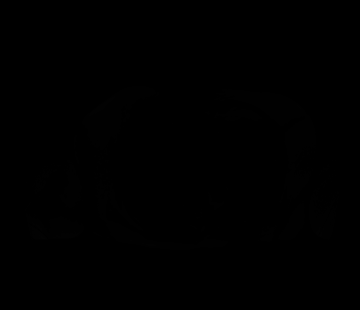

In [55]:
image_path = "case11/case11_day13/scans/slice_0023_360_310_1.50_1.50.png"
image_path = os.path.join(train_root_path, image_path)

image = Image.open(image_path)
image

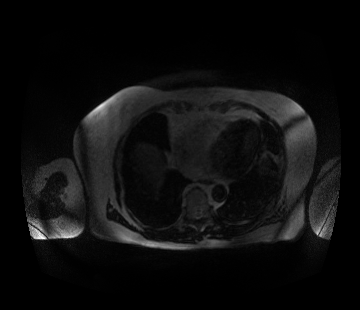

In [56]:
image = To8bit(image)
image

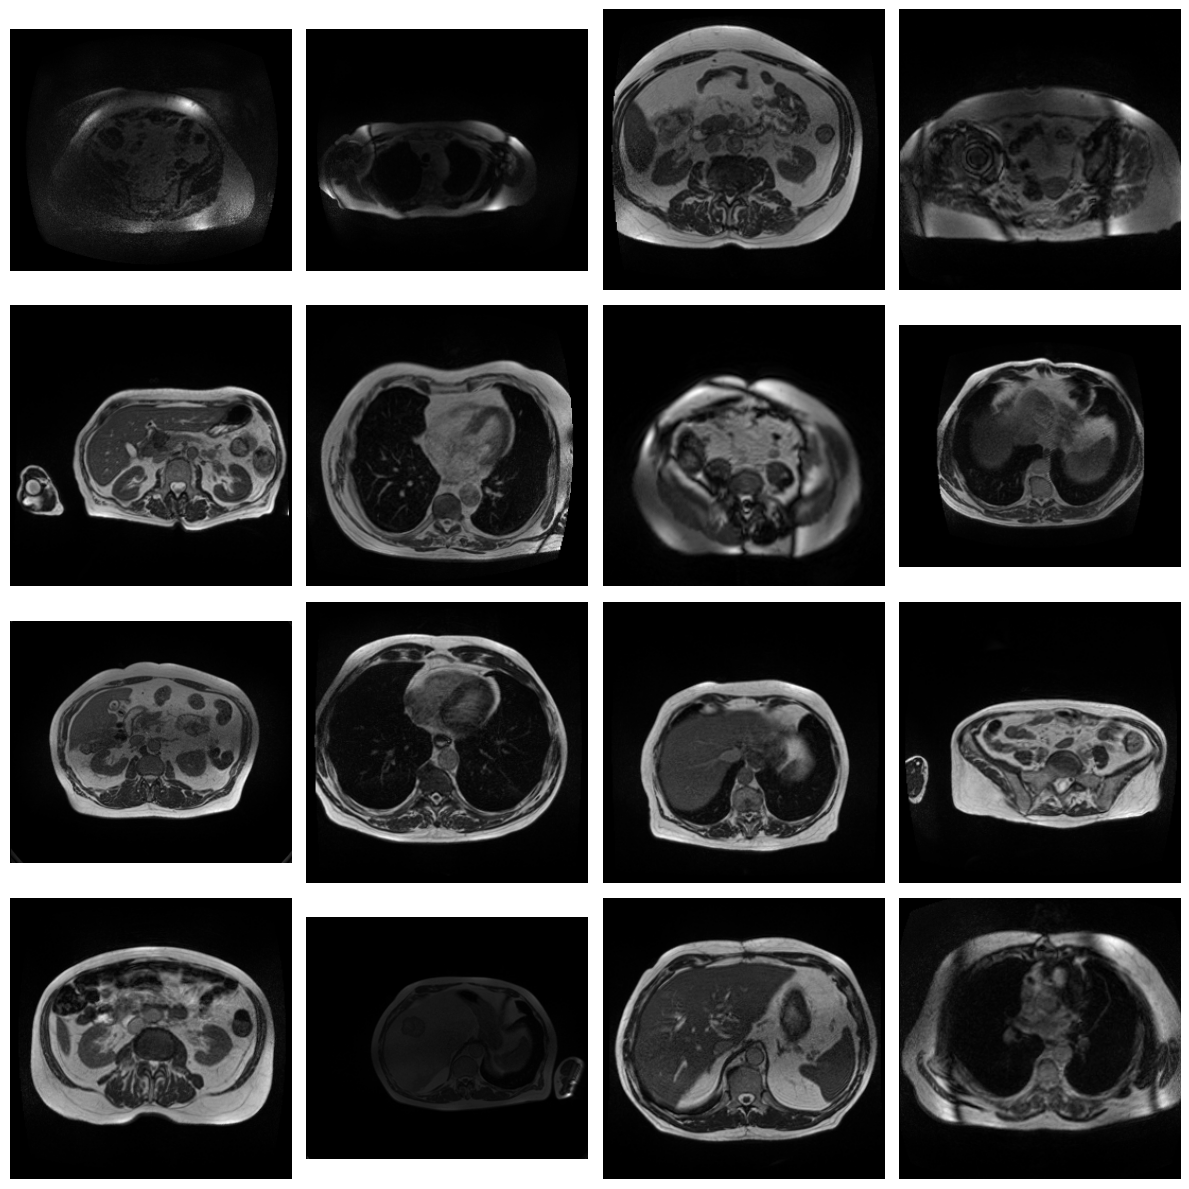

In [58]:
images = []
for i in range(16):
    image_path = random_sample(train_root_path)
    image = Image.open(os.path.join(train_root_path, image_path))
    image = To8bit(image)
    images.append(image)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 🟡 Draw segments on image

case66/case66_day36/scans/slice_0084_266_266_1.50_1.50.png
<class 'torch.Tensor'>


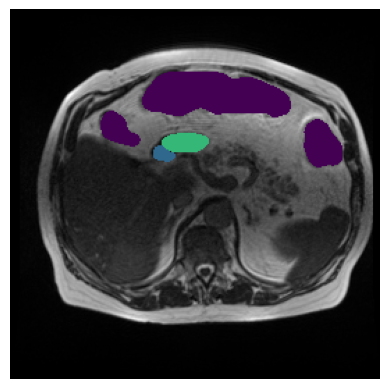

In [280]:
image_path = random_sample(train_root_path)
print(image_path)
image = F.to_tensor(Image.open(os.path.join(train_root_path, image_path)))
image = To8bit(image)
image = image.repeat(3, 1, 1)

masks = GetMasks(image_path, ann_path, train_root_path)

image = DrawMask(image, masks)
plt.imshow(image)
plt.axis('off')
plt.show()

case142/case142_day14/scans/slice_0069_266_266_1.50_1.50.png
case144/case144_day15/scans/slice_0058_266_266_1.50_1.50.png
case85/case85_day21/scans/slice_0026_266_266_1.50_1.50.png


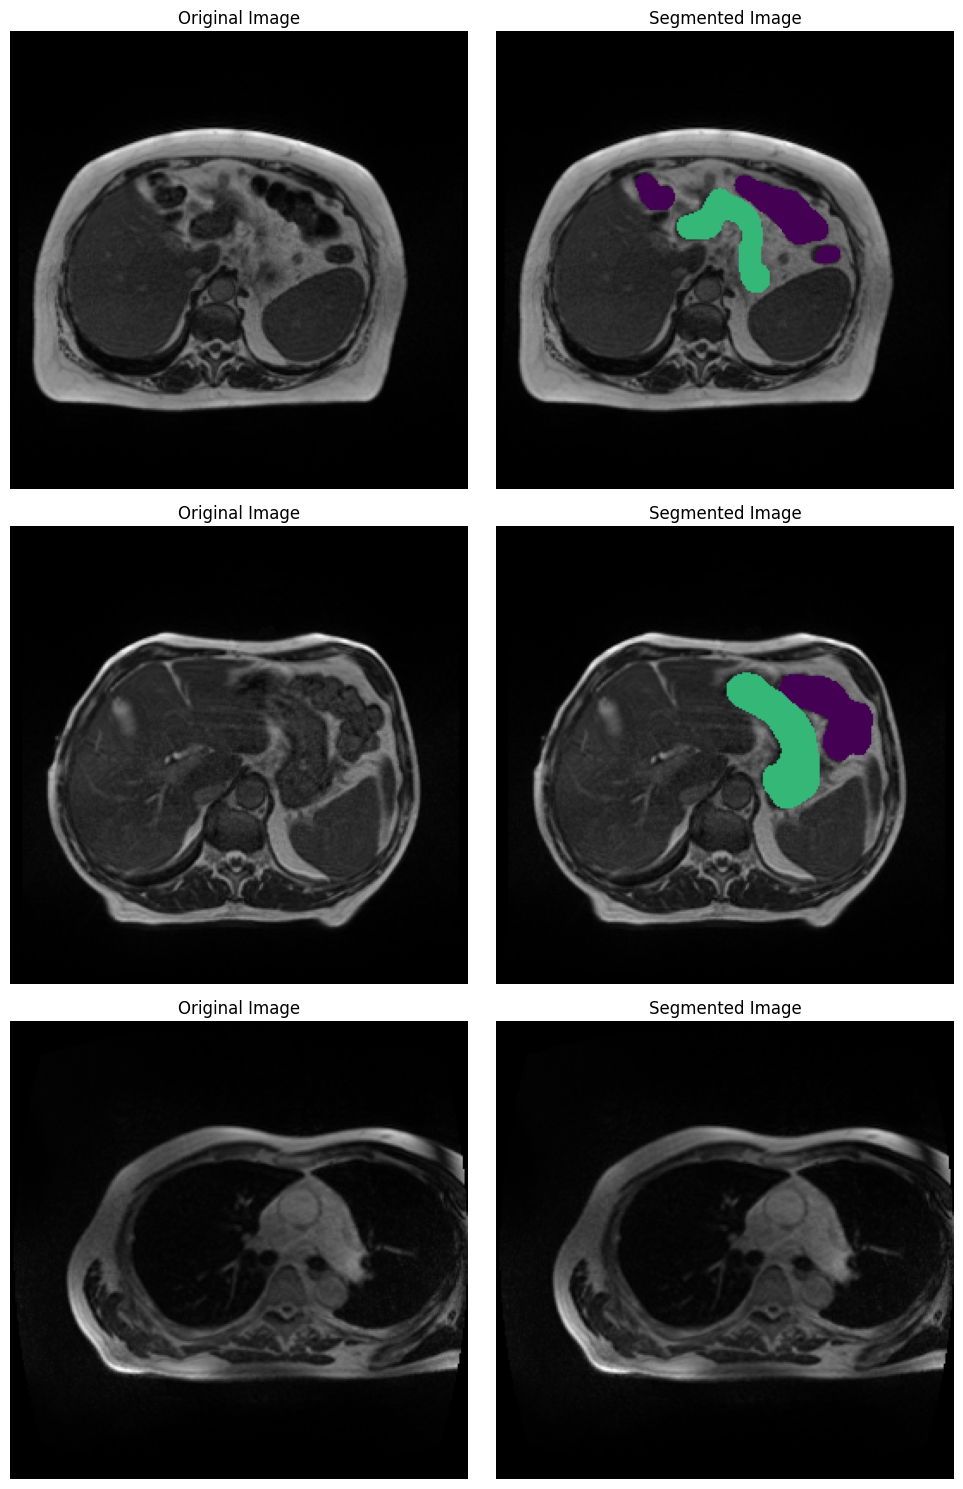

In [194]:
# image_path = "case123/case123_day20/scans/slice_0092_266_266_1.50_1.50.png"
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    image_path = random_sample(train_root_path)
    print(image_path)
    
    # Open Image
    image = F.to_tensor(Image.open(os.path.join(train_root_path, image_path)))
    image = To8bit(image)
    image = image.repeat(3, 1, 1)
    
    masks = GetMasks(image_path, ann_path, train_root_path)

    masked_image = DrawMask(image, masks)
    
    axes[i, 0].imshow(image[0], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(masked_image)
    axes[i, 1].set_title('Segmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### 🟡 Plot some histograms

In [222]:
df.head()

,id,class,segmentation,case,day,slice,image_path
0,case123_day20_slice_0001,large_bowel,NaN,case123,20,0001,case123\case123_day20\scans\slice_0001_266_266...
1,case123_day20_slice_0001,small_bowel,NaN,case123,20,0001,case123\case123_day20\scans\slice_0001_266_266...
2,case123_day20_slice_0001,stomach,NaN,case123,20,0001,case123\case123_day20\scans\slice_0001_266_266...
3,case123_day20_slice_0002,large_bowel,NaN,case123,20,0002,case123\case123_day20\scans\slice_0002_266_266...
4,case123_day20_slice_0002,small_bowel,NaN,case123,20,0002,case123\case123_day20\scans\slice_0002_266_266...


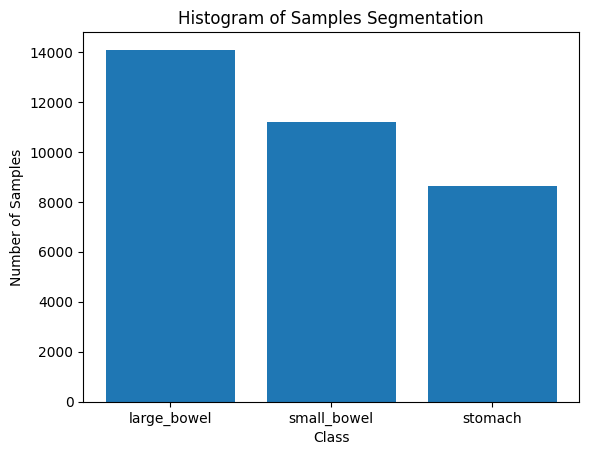

In [224]:
# Count the number of samples for each class
filtered_df = df[pd.notna(df['segmentation'])]
class_counts = filtered_df['class'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Histogram of Samples Segmentation')
plt.show()

Mean Number of Images per Case:  398.9764705882353


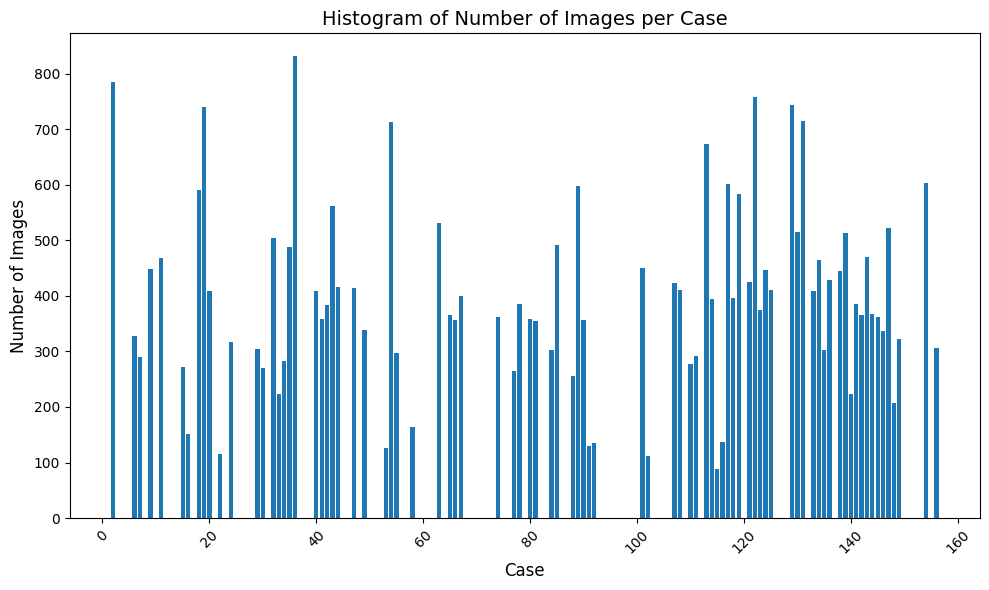

In [241]:
filtered_df = df[pd.notna(df['segmentation'])]
case_counts = filtered_df['case'].value_counts()
case_numbers = [int(case[4:]) for case in case_counts.index]

print("Mean Number of Images per Case: ", np.mean(case_counts.values))

plt.figure(figsize=(10, 6))
plt.bar(case_numbers, case_counts.values, width=0.8)
plt.xlabel('Case', fontsize=12) 
plt.ylabel('Number of Images', fontsize=12) 
plt.title('Histogram of Number of Images per Case', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## 🟠 Custom dataset

In [338]:
class UW_Dataset(Dataset):
    def __init__(self, root_path, ann_path, ann_list_file, transform=None):
        self.root_path = root_path
        self.ann_path = ann_path
        self.transform = transform

        cases = []
        with open(ann_list_file, "r") as file:
            for line in file:
                case = line.strip()
                cases.append(case)
                
        self.images_path = []
        # for case in cases:
        #     samples = os.listdir(os.path.join(root_path, case, "scans"))
        #     for sample in samples:
        #         images_path.append(os.path.join(root_path, case, "scans", sample))
        for case in cases:
            days = os.listdir(root_path + '/' + case)
            for day in days:
                samples = os.listdir(root_path + '/' + case + '/' + day + "/scans")
                for sample in samples:
                    self.images_path.append(case + '/' + day + "/scans/" + sample)
            

    def __getitem__(self, idx):
        image = tv.Image(Image.open(os.path.join(self.root_path, self.images_path[idx])))
        image = To8bit(image)
        
        mask = GetMasks(self.images_path[idx], self.ann_path, self.root_path)
        mask = tv.Mask(mask)

        if self.transform != None:
            image, mask = self.transform(image, mask)
            
        return image, mask
        

    def __len__(self):
        return len(self.images_path)

In [348]:
train_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomCrop(size=(224, 224)),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

test_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    ])

In [349]:
train_set = UW_Dataset(train_root_path, ann_path, os.path.join("train_test_split", "train.txt"), transform=train_transform)
val_set = UW_Dataset(train_root_path, ann_path, os.path.join("train_test_split", "validation.txt"), transform=test_transform)
test_set = UW_Dataset(train_root_path, ann_path, os.path.join("train_test_split", "test.txt"), transform=test_transform)

In [350]:
image, mask = train_set[100]
print(image.shape)
print(mask.shape)

torch.Size([1, 224, 224])
torch.Size([3, 224, 224])


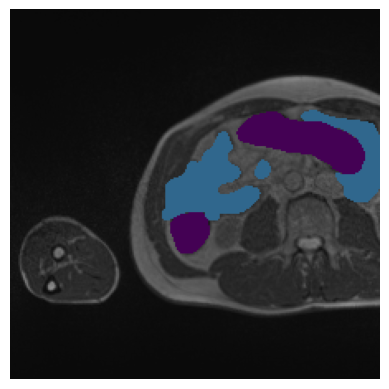

In [351]:
image_temp = image.repeat(3, 1, 1)
image_temp = DrawMask(image_temp, mask)
plt.imshow(image_temp)
plt.axis('off')
plt.show()

## 🟠 Dataloader

In [352]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [353]:
image, mask = next(iter(train_loader))
print(image.shape)
print(mask.shape)

torch.Size([4, 1, 224, 224])
torch.Size([4, 3, 224, 224])


# 🔴 **Model**

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model =

inputs, targets = next(iter(train_set))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model =
optimizer = torch.optim.SGD(model.parameters(), lr=, momentum=0.9)

In [ ]:
num_epochs = ...
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, ..., loss_fn, optimizer, metric, epoch)

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs =

for lr in [...]:
  print(f'LR={lr}')

  model =
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_set, loss_fn, optimizer, metric, epoch)

  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define train dataloader.

In [ ]:
set_seed(seed)
train_loader =

🔰 Define model.

In [ ]:
set_seed(seed)
model =

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

In [ ]:
wandb.finish()

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

# 🔴 **Segment**

🔰 Your mission is to write a `segmentation` function and use a test image to see the prediction of the model.

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()